In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.1.0


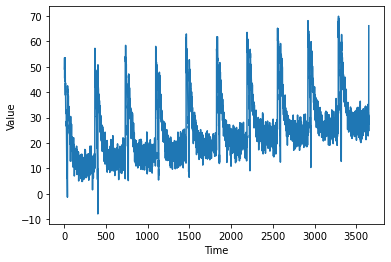

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [4]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 10.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 8s 80ms/step - loss: 20.5108 - mae: 20.8828
Epoch 2/100
94/94 [==============================] - 2s 26ms/step - loss: 20.4309 - mae: 20.8543
Epoch 3/100
94/94 [==============================] - 2s 25ms/step - loss: 20.3439 - mae: 20.8218
Epoch 4/100
94/94 [==============================] - 3s 28ms/step - loss: 20.3271 - mae: 20.7851
Epoch 5/100
94/94 [==============================] - 3s 29ms/step - loss: 20.2817 - mae: 20.7436
Epoch 6/100
94/94 [==============================] - 3s 29ms/step - loss: 20.1741 - mae: 20.6964
Epoch 7/100
94/94 [==============================] - 3s 30ms/step - loss: 20.1283 - mae: 20.6429
Epoch 8/100
94/94 [==============================] - 2s 24ms/step - loss: 20.0414 - mae: 20.5822
Epoch 9/100
94/94 [==============================] - 2s 23ms/step - loss: 20.0238 - mae: 20.5140
Epoch 10/100
94/94 [==============================] - 2s 23ms/step - loss: 19.9251 - mae: 20.4385
Epoch 11/100
94/94 [=========

94/94 [==============================] - 5s 48ms/step - loss: 3.0710 - mae: 3.5096
Epoch 85/100
94/94 [==============================] - 4s 41ms/step - loss: 3.0327 - mae: 3.5118
Epoch 86/100
94/94 [==============================] - 3s 36ms/step - loss: 3.0431 - mae: 3.5000
Epoch 87/100
94/94 [==============================] - 3s 34ms/step - loss: 3.0150 - mae: 3.4788
Epoch 88/100
94/94 [==============================] - 3s 31ms/step - loss: 3.0400 - mae: 3.5042
Epoch 89/100
94/94 [==============================] - 3s 28ms/step - loss: 2.9029 - mae: 3.3685
Epoch 90/100
94/94 [==============================] - 3s 30ms/step - loss: 3.1900 - mae: 3.6504
Epoch 91/100
94/94 [==============================] - 3s 29ms/step - loss: 3.2336 - mae: 3.7017
Epoch 92/100
94/94 [==============================] - 3s 32ms/step - loss: 2.9400 - mae: 3.4112
Epoch 93/100
94/94 [==============================] - 3s 31ms/step - loss: 3.0258 - mae: 3.5193
Epoch 94/100
94/94 [==============================] -

(1e-08, 0.0001, 0.0, 30.0)

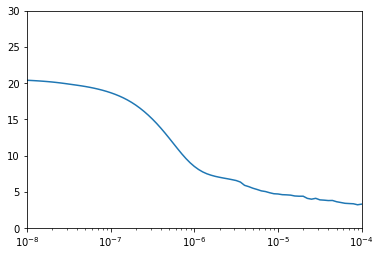

In [5]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500
94/94 [==============================] - 10s 110ms/step - loss: 317.3268 - mae: 10.6099
Epoch 2/500
94/94 [==============================] - 3s 36ms/step - loss: 38.8102 - mae: 4.1943
Epoch 3/500
94/94 [==============================] - 3s 30ms/step - loss: 33.0714 - mae: 3.9061
Epoch 4/500
94/94 [==============================] - 3s 31ms/step - loss: 28.5533 - mae: 3.5994
Epoch 5/500
94/94 [==============================] - 3s 36ms/step - loss: 31.2759 - mae: 3.8953
Epoch 6/500
94/94 [==============================] - 3s 35ms/step - loss: 27.3961 - mae: 3.5512
Epoch 7/500
94/94 [==============================] - 4s 39ms/step - loss: 26.2363 - mae: 3.4617
Epoch 8/500
94/94 [==============================] - 5s 50ms/step - loss: 30.7591 - mae: 3.8562
Epoch 9/500
94/94 [==============================] - 5s 52ms/step - loss: 28.1300 - mae: 3.6017
Epoch 10/500
94/94 [==============================] - 6s 68ms/step - loss: 29.8297 - mae: 3.8046
Epoch 11/500
94/94 [===============

94/94 [==============================] - 3s 28ms/step - loss: 22.8106 - mae: 3.2693
Epoch 86/500
94/94 [==============================] - 2s 27ms/step - loss: 21.7444 - mae: 3.1244
Epoch 87/500
94/94 [==============================] - 3s 27ms/step - loss: 22.6611 - mae: 3.1995
Epoch 88/500
94/94 [==============================] - 3s 27ms/step - loss: 24.1897 - mae: 3.4071
Epoch 89/500
94/94 [==============================] - 3s 27ms/step - loss: 21.8827 - mae: 3.1387
Epoch 90/500
94/94 [==============================] - 3s 28ms/step - loss: 23.5019 - mae: 3.2741
Epoch 91/500
94/94 [==============================] - 3s 28ms/step - loss: 22.6874 - mae: 3.2437
Epoch 92/500
94/94 [==============================] - 3s 28ms/step - loss: 22.9606 - mae: 3.2601
Epoch 93/500
94/94 [==============================] - 3s 28ms/step - loss: 23.0044 - mae: 3.2595
Epoch 94/500
94/94 [==============================] - 3s 29ms/step - loss: 22.0056 - mae: 3.1581
Epoch 95/500
94/94 [=======================

94/94 [==============================] - 3s 28ms/step - loss: 20.8968 - mae: 3.0795
Epoch 169/500
94/94 [==============================] - 3s 28ms/step - loss: 21.1168 - mae: 3.1363
Epoch 170/500
94/94 [==============================] - 3s 28ms/step - loss: 20.7971 - mae: 3.0765
Epoch 171/500
94/94 [==============================] - 3s 28ms/step - loss: 20.2496 - mae: 3.0223
Epoch 172/500
94/94 [==============================] - 3s 29ms/step - loss: 20.8936 - mae: 3.0939
Epoch 173/500
94/94 [==============================] - 3s 27ms/step - loss: 20.1975 - mae: 3.0034
Epoch 174/500
94/94 [==============================] - 3s 27ms/step - loss: 20.4068 - mae: 3.0208
Epoch 175/500
94/94 [==============================] - 3s 29ms/step - loss: 20.6304 - mae: 3.0750
Epoch 176/500
94/94 [==============================] - 3s 27ms/step - loss: 20.6705 - mae: 3.0845
Epoch 177/500
94/94 [==============================] - 3s 29ms/step - loss: 20.8028 - mae: 3.0946
Epoch 178/500
94/94 [=============

94/94 [==============================] - 2s 21ms/step - loss: 20.2157 - mae: 3.0015
Epoch 252/500
94/94 [==============================] - 2s 21ms/step - loss: 20.7970 - mae: 3.1064
Epoch 253/500
94/94 [==============================] - 2s 21ms/step - loss: 21.1073 - mae: 3.0715
Epoch 254/500
94/94 [==============================] - 2s 22ms/step - loss: 20.1917 - mae: 2.9903
Epoch 255/500
94/94 [==============================] - 2s 21ms/step - loss: 20.0015 - mae: 2.9854
Epoch 256/500
94/94 [==============================] - 2s 22ms/step - loss: 20.4626 - mae: 3.0651
Epoch 257/500
94/94 [==============================] - 2s 22ms/step - loss: 20.6591 - mae: 3.0463
Epoch 258/500
94/94 [==============================] - 2s 21ms/step - loss: 20.3561 - mae: 3.0352
Epoch 259/500
94/94 [==============================] - 2s 21ms/step - loss: 20.1186 - mae: 2.9619
Epoch 260/500
94/94 [==============================] - 2s 21ms/step - loss: 20.9900 - mae: 3.0915
Epoch 261/500
94/94 [=============

94/94 [==============================] - 2s 20ms/step - loss: 20.4520 - mae: 3.0269
Epoch 335/500
94/94 [==============================] - 2s 21ms/step - loss: 20.8418 - mae: 3.0924
Epoch 336/500
94/94 [==============================] - 2s 21ms/step - loss: 20.0627 - mae: 3.0260
Epoch 337/500
94/94 [==============================] - 2s 21ms/step - loss: 19.9868 - mae: 3.0029
Epoch 338/500
94/94 [==============================] - 2s 21ms/step - loss: 19.9737 - mae: 2.9751
Epoch 339/500
94/94 [==============================] - 2s 21ms/step - loss: 19.4479 - mae: 2.9169
Epoch 340/500
94/94 [==============================] - 2s 21ms/step - loss: 20.1823 - mae: 3.0045
Epoch 341/500
94/94 [==============================] - 2s 21ms/step - loss: 20.4080 - mae: 3.0369
Epoch 342/500
94/94 [==============================] - 2s 20ms/step - loss: 19.5784 - mae: 2.9437
Epoch 343/500
94/94 [==============================] - 2s 21ms/step - loss: 19.5053 - mae: 2.9311
Epoch 344/500
94/94 [=============

94/94 [==============================] - 2s 21ms/step - loss: 20.0046 - mae: 2.9557
Epoch 418/500
94/94 [==============================] - 2s 21ms/step - loss: 20.0487 - mae: 3.0012
Epoch 419/500
94/94 [==============================] - 2s 21ms/step - loss: 19.4766 - mae: 2.9308
Epoch 420/500
94/94 [==============================] - 2s 21ms/step - loss: 19.8192 - mae: 2.9668
Epoch 421/500
94/94 [==============================] - 2s 21ms/step - loss: 19.7327 - mae: 2.9809
Epoch 422/500
94/94 [==============================] - 2s 20ms/step - loss: 20.4556 - mae: 3.0400
Epoch 423/500
94/94 [==============================] - 2s 20ms/step - loss: 19.5229 - mae: 2.9492
Epoch 424/500
94/94 [==============================] - 2s 20ms/step - loss: 19.7285 - mae: 2.9634
Epoch 425/500
94/94 [==============================] - 2s 20ms/step - loss: 20.5013 - mae: 3.0568
Epoch 426/500
94/94 [==============================] - 2s 21ms/step - loss: 20.1319 - mae: 3.0081
Epoch 427/500
94/94 [=============

94/94 [==============================] - 2s 21ms/step - loss: 20.5952 - mae: 3.0503


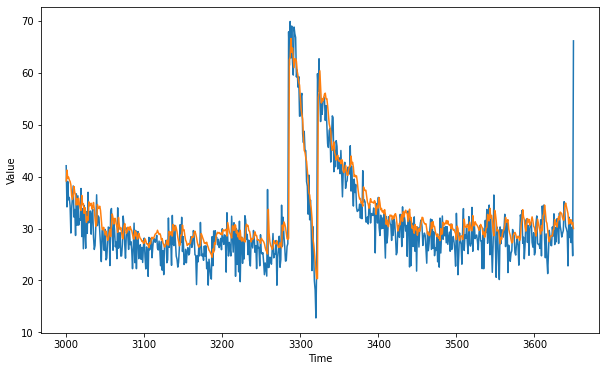

In [7]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [8]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

3.3967009

<Figure size 432x288 with 0 Axes>

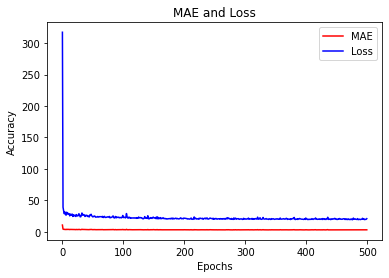

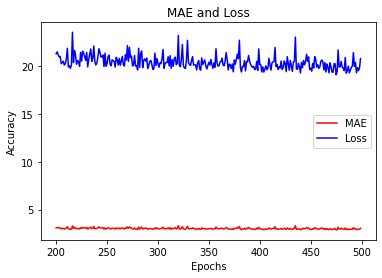

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()